In [0]:
from skimage import color
from skimage import io
from matplotlib import pyplot as plt
import scipy
import numpy as np
from mpl_toolkits import mplot3d
from scipy import signal
import cv2
from google.colab import files
from scipy.ndimage.filters import convolve
from google.colab.patches import cv2_imshow
import numpy.linalg as LA

In [0]:
! git clone https://github.com/shreyanshu09/image.git

fatal: destination path 'image' already exists and is not an empty directory.


# **Harris corner detector in get_interest_points( )**

In [0]:
# Read image and converting into grayscale
originalImg = io.imread('/content/image/house1.jpg')
gray = cv2.cvtColor(originalImg,cv2.COLOR_BGR2GRAY)

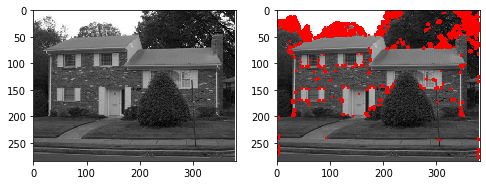

In [0]:
# Spatial derivative calculation
     # Sobel filter to obtain the derivatives
def gradient_x(imggray):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return signal.convolve2d(imggray, kernel_x, mode='same')
def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return signal.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(gray)
I_y = gradient_y(gray)

#Second-Order Derivatives of Image
def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

I_xx = I_x**2
I_xy = I_x*I_y
I_yy = I_y**2

gKernel = gaussian_kernel(5, 1.4)
gI_xx = signal.convolve2d(I_xx, gKernel, mode='same')
gI_xy = signal.convolve2d(I_xy, gKernel, mode='same')
gI_yy = signal.convolve2d(I_yy, gKernel, mode='same')

#Harris response calculation
image_copy = color.gray2rgb(gray)
height = gray.shape[0]
width = gray.shape[1]
alpha = 0.04
window_size = 5
offset = window_size

corner = np.zeros((height, width), np.float32)
for y in range(window_size, height-window_size):
    for x in range(window_size, width-window_size):
        Sxx = np.sum(gI_xx[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(gI_xy[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(gI_yy[y-offset:y+1+offset, x-offset:x+1+offset])

        det = Sxx * Syy - Sxy**2
        trace = Sxx + Syy
        corner[y,x] = det - alpha*trace**2

thresh = 0.01*corner.max()
image_copy[corner > thresh] = [255, 0, 0]

#Harris corner detection
dest = cv2.cornerHarris(gray, window_size, 3, 0.04)
dest = cv2.dilate(dest, None)
image_copy = color.gray2rgb(gray)
image_copy[dest > 0.01 * dest.max()] = [255, 0, 0]

fig, axs = plt.subplots(1, 2, figsize=(8,6.5))
axs[0].imshow(gray, cmap='gray')
axs[1].imshow(image_copy)
plt.show()

# **SIFT-like local feature in get_features( )**

**The SIFT algorithm has four main steps:**

1. Scale-Space Extrema Detection
2. Keypoint Localization
3. Orientation Assignment
4. Local Descriptor Creation

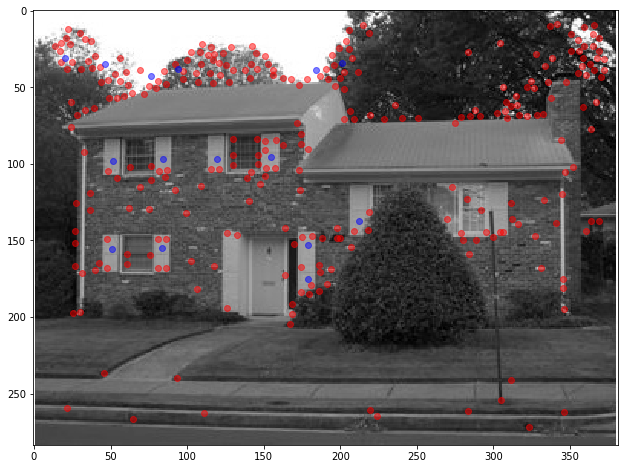

In [0]:
# We need a Gaussian 􀂦lter for creation of the Gaussian octave
def gaussian_filter(sigma):
  size = 2*np.ceil(3*sigma)+1
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

# We need to select sigma and repeatedly convolve with the Gaussian filter
def generate_octave(init_level, s, sigma):
  octave = [init_level]
  k = 2**(1/s)
  kernel = gaussian_filter(k * sigma)
  for _ in range(s+2):
    next_level = convolve(octave[-1], kernel)
    octave.append(next_level)
  return octave

# sigma parameter is used to scale which is used to generate the whole Gaussian pyramid:
def generate_gaussian_pyramid(im, num_octave, s, sigma):
  pyr = []
  for _ in range(num_octave):
    octave = generate_octave(im, s, sigma)
    pyr.append(octave)
    im = octave[-3][::2, ::2]
  return pyr

# Since we generate s+3 images per octave, we use the third to last image as the base for the next octave 
# Now that we have the Gaussian pyramid, it is trivial to create the DoG pyramid:
def generate_DoG_octave(gaussian_octave):
  octave = []
  
  for i in range(1, len(gaussian_octave)):
    octave.append(gaussian_octave[i] - gaussian_octave[i-1])

  return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
  pyr = []
  for gaussian_octave in gaussian_pyramid:
    pyr.append(generate_DoG_octave(gaussian_octave))

  return pyr

def get_candidate_keypoints(D, w=16):
  candidates = []
  D[:,:,0] = 0
  D[:,:,-1] = 0
  for i in range(w//2+1, D.shape[0]-w//2-1):
    for j in range(w//2+1, D.shape[1]-w//2-1):
      for k in range(1, D.shape[2]-1):
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
        if np.argmax(patch) == 13 or np.argmin(patch) == 13:
          candidates.append([i, j, k])
  return candidates

# Computing the subpixel location of each keypoint
def localize_keypoint(D, x, y, s):
  dx = (D[y,x+1,s]-D[y,x-1,s])/2.0
  dy = (D[y+1,x,s]-D[y-1,x,s])/2.0
  ds = (D[y,x,s+1]-D[y,x,s-1])/2.0
  dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
  dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.0
  dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.0
  dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
  dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.0
  dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]
  J = np.array([dx, dy, ds])
  HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
  offset = -LA.inv(HD).dot(J)
  return offset, J, HD[:2,:2], x, y, s

def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
  candidates = get_candidate_keypoints(D, w)
  keypoints = []
  
  for i, cand in enumerate(candidates):
    y, x, s = cand[0], cand[1], cand[2]
    offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

    contrast = D[y,x,s] + .5*J.dot(offset)
    if abs(contrast) < t_c: continue

    w, v = LA.eig(H)
    r = w[1]/w[0]
    R = (r+1)**2 / r
    if R > R_th: continue

    kp = np.array([x, y, s]) + offset
    keypoints.append(kp)

  return np.array(keypoints)

def get_keypoints(DoG_pyr, R_th, t_c, w):
  kps = []
  for D in DoG_pyr:
    kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))
    
  return kps

gray_image = color.rgb2gray(io.imread('/content/image/house1.jpg'))
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)
kps = get_keypoints(dog_pyramid, (10+1)**2/10.0, 0.03, 16) 

def myDrawKeypoints(image, kps):
  fig, axs = plt.subplots(1,1, figsize=(12,8))
  axs.imshow(image, cmap='gray')
  h = image.shape[0]
  colors=['blue', 'red']
  for o in range(len(kps)):
      if len(kps[o]) == 0: continue
      scale = 2**o
      for j, pt in enumerate(kps[o]):
          x, y, s = pt[0]*scale, pt[1]*scale, pt[2]
          axs.scatter(x, y, color=colors[o-1], alpha=0.5)

myDrawKeypoints(gray_image, kps)

# **"Ratio Test" matching with various distance measure in match_features( )**

In [0]:
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving house1.jpg to house1 (1).jpg
Saving house2.jpg to house2 (2).jpg
Saving rotated_house.jpg to rotated_house (3).jpg
User uploaded file "house1.jpg" with length 45139 bytes
User uploaded file "house2.jpg" with length 40634 bytes
User uploaded file "rotated_house.jpg" with length 41783 bytes


-----------------------IMAGE 1-----------------------


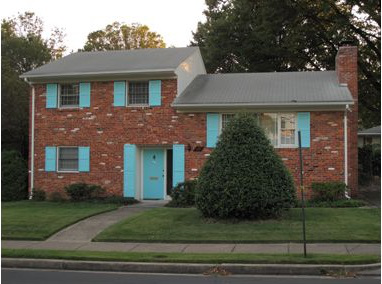


-----------------------IMAGE 2-----------------------


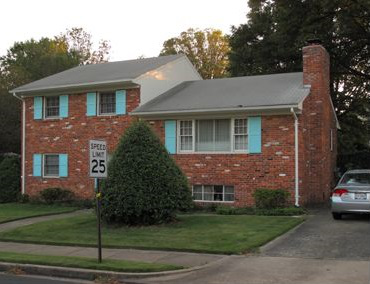

In [0]:
# Read image 
img1 = cv2.imread('house1.jpg',1)

img2 = cv2.imread('house2.jpg',1)

print('-----------------------IMAGE 1-----------------------')
cv2_imshow(img1)

print('\n-----------------------IMAGE 2-----------------------')
cv2_imshow(img2)

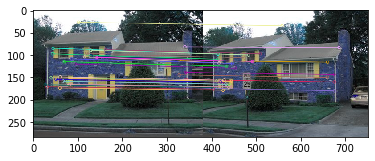

In [0]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BF(brute force)Matcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3)
plt.show()

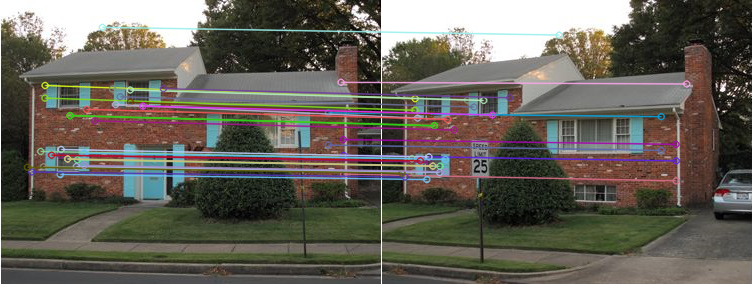

In [0]:
cv2_imshow(img3)

# **Experiments on several issues like 'scale', 'illumination change', 'rotation', etc**

**Now lets rotate the image_2 by 90 degree and run SIFT on it,**



-----------------------IMAGE-----------------------


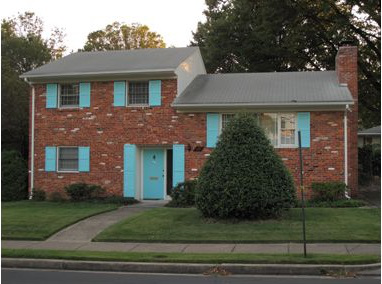


-----------------------IMAGE ROTATED BY 90 Degree-----------------------


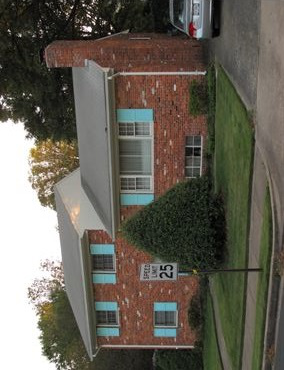

In [0]:
# Read image 
img = cv2.imread('house1.jpg',1)

img_rotate= cv2.imread('rotated_house.jpg',1)


print('-----------------------IMAGE-----------------------')
cv2_imshow(img)

print('\n-----------------------IMAGE ROTATED BY 90 Degree-----------------------')
cv2_imshow(img_rotate)

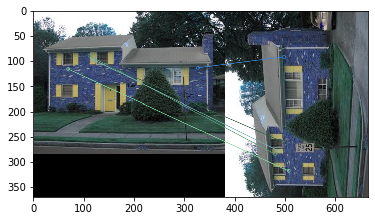

In [0]:
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(img_rotate,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append([m])
        
res2 = cv2.drawMatchesKnn(img,kp1,img_rotate,kp2,good,None,flags=2)
plt.imshow(res2)
plt.show()

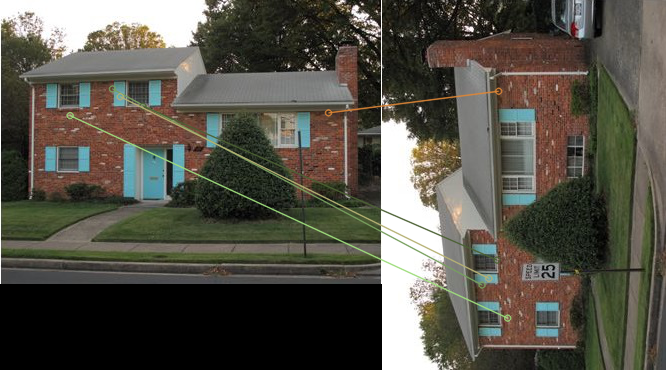

In [0]:
cv2_imshow(res2)

**We can clearly see that even though the image has been rotated yet it captured the match in the image but does not matches all**

**The above undetected parts can be solved by increasing the threshold although the noise make it indistinguishable**

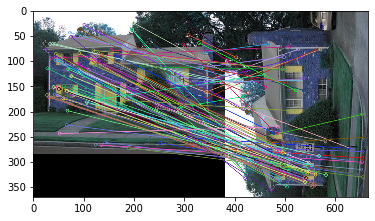

In [0]:
good1 = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good1.append([m])

res3 = cv2.drawMatchesKnn(img,kp1,img_rotate,kp2,good1,None,flags=2)
plt.imshow(res3)
plt.show()

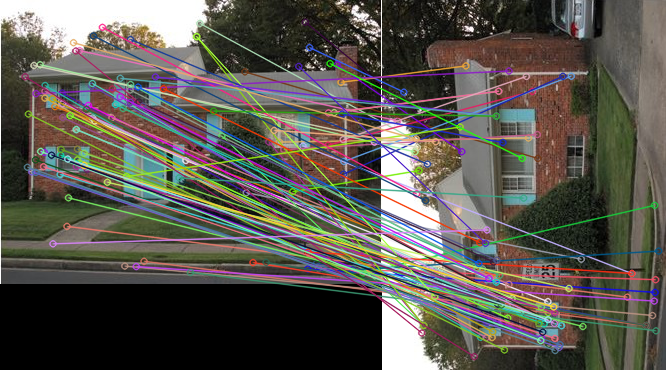

In [0]:
cv2_imshow(res3)

## In the above image we can see that almost all part has been detected along with some noise and FP points

# **Comparing results with other descriptors like ORB, SURF, DAISY, BRIEF, etc**

-----------------------IMAGE-----------------------


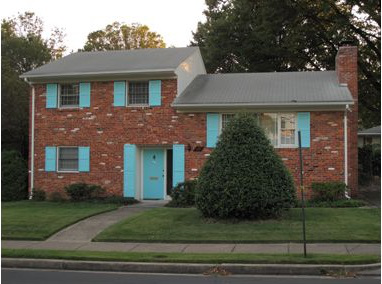


-----------------------IMAGE Rotated by 90 degree-----------------------


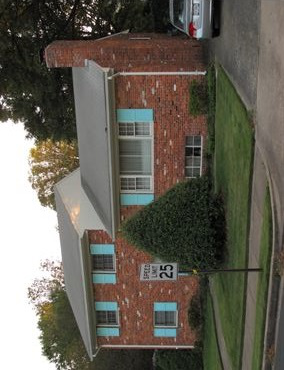

In [0]:
# Read image 
image1 = cv2.imread('house1.jpg',1)
image2 = cv2.imread('rotated_house.jpg',1)

print('-----------------------IMAGE-----------------------')
cv2_imshow(image1)

print('\n-----------------------IMAGE Rotated by 90 degree-----------------------')
cv2_imshow(image2)

**SIFT :**
SIFT proposed by Lowe solves the image rotation, affine
transformations, intensity, and viewpoint change in matching
features. The SIFT algorithm has 4 basic steps. First is to
estimate a scale space extrema using the Difference of
Gaussian (DoG). Secondly, a key point localization where the
key point candidates are localized and refined by eliminating
the low contrast points. Thirdly, a key point orientation
assignment based on local image gradient and lastly a
descriptor generator to compute the local image descriptor for
each key point based on image gradient magnitude and
orientation

In [0]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Convering to Gray
img1= cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
img2= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# no.of keypoints 
print("Keypoints for 1st Image: ")
print(len(des1))
print("Keypoints for 2nd Image: ")
print(len(des2))

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)


# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

print("matches: ")
print(len(good))

Keypoints for 1st Image: 
736
Keypoints for 2nd Image: 
653
matches: 
80


**SURF:**
SURF approximates the DoG with box filters. Instead of
Gaussian averaging the image, squares are used for
approximation since the convolution with square is much
faster if the integral image is used. Also this can be done in
parallel for different scales. The SURF uses a BLOB detector
which is based on the Hessian matrix to find the points of
interest. For orientation assignment, it uses wavelet responses
in both horizontal and vertical directions by applying adequate
Gaussian weights. For feature description also SURF uses the
wavelet responses. A neighborhood around the key point is
selected and divided into subregions and then for each
subregion the wavelet responses are taken and represented to
get SURF feature descriptor. The sign of Laplacian which is
already computed in the detection is used for underlying
interest points. The sign of the Laplacian distinguishes bright
blobs on dark backgrounds from the reverse case. In case of
matching the features are compared only if they have same
type of contrast (based on sign) which allows faster matching .

In [0]:
# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create()

# Convering to Gray
img1= cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
img2= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

# find the keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)

# no.of keypoints 
print("Keypoints for 1st Image: ")
print(len(des1))
print("Keypoints for 2nd Image: ")
print(len(des2))

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

print("matches ")
print(len(good))


Keypoints for 1st Image: 
917
Keypoints for 2nd Image: 
895
matches 
91


**ORB :**
ORB is a fusion of the FAST key point detector and BRIEF
descriptor with some modifications. Initially to determine
the key points, it uses FAST. Then a Harris corner measure is
applied to find top N points. FAST does not compute the
orientation and is rotation variant. It computes the intensity
weighted centroid of the patch with located corner at center.
The direction of the vector from this corner point to centroid
gives the orientation. Moments are computed to improve the
rotation invariance. The descriptor BRIEF poorly per forms if
there is an in-plane rotation. In ORB, a rotation matrix is
computed using the orientation of patch and then the BRIEF
descriptors are steered according to the orientation.

In [0]:
# Initiate ORB detector
orb = cv2.ORB_create()

# Convering to Gray
img1= cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
img2= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# no.of keypoints 
print("Keypoints for 1st Image: ")
print(len(des1))
print("Keypoints for 2nd Image: ")
print(len(des2))

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

print("matches ")
print(len(good))


Keypoints for 1st Image: 
470
Keypoints for 2nd Image: 
475
matches 
14


**CONCLUSION :**

After comparing SIFT, SURF and ORB, we can notice ORB is the fast algorithm. From the result, we can assume ORB gets keypoint more efficient than others because matching rate% is very high as compared with other two. Nowadays SURF not in use. SIFT doing great work, but I assume that the ORB will give a more good result for researches.